In [19]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

stocks = pd.read_excel("data.xlsx")

In [9]:
stocks.columns = ['date', 'aapl', 'cisco', 'ibm', 'amzn']
stocks = stocks.set_index("date")
stocks.head()

,aapl,cisco,ibm,amzn
date,,,,
2012-01-03,51.269388,14.852511,145.550852,179.03
2012-01-04,51.544916,15.139516,144.957086,177.51
2012-01-05,52.117167,15.083709,144.269567,177.61
2012-01-06,52.661989,15.027903,142.613272,182.61
2012-01-09,52.578458,15.123571,141.871064,178.56


In [10]:
#log_ret = np.log(stocks) - np.log(stocks.shift(1))
log_ret = stocks.pct_change()
log_ret.head()

,aapl,cisco,ibm,amzn
date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.019324,-0.004079,-0.008490
2012-01-05,0.011102,-0.003686,-0.004743,0.000563
2012-01-06,0.010454,-0.003700,-0.011481,0.028152
2012-01-09,-0.001586,0.006366,-0.005204,-0.022178


In [15]:
#np.random.seed(42)
num_ports = 10000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252))
    #ret_arr[x] = np.sum( (log_ret.mean() * weights))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    #vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov(), weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [16]:
print("Max Sharpe ratio in the array: ", sharpe_arr.max())
print("Its location in the array: ", sharpe_arr.argmax())

Max Sharpe ratio in the array:  1.615055288323884
Its location in the array:  9365


In [17]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

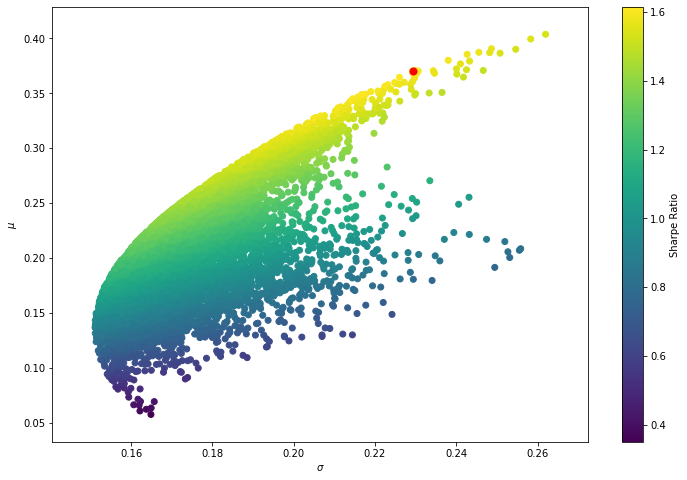

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\mu$')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

In [53]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [54]:
cons = {"type":"eq","fun":check_sum}
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]

In [55]:
opt_results = minimize(neg_sharpe, init_guess, method="SLSQP", bounds=bounds, constraints=cons)
print(opt_results)

     fun: -1.616710692734543
     jac: array([-3.86014581e-04, -2.64137983e-04,  2.23171979e-01,  1.80512667e-04])
 message: 'Optimization terminated successfully.'
    nfev: 43
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.49727832e-01, 8.77898684e-02, 6.38595080e-17, 6.62482300e-01])


In [56]:
get_ret_vol_sr(opt_results.x)

array([0.36203815, 0.22393503, 1.61671069])

In [57]:
frontier_y = np.linspace(0,0.45,500)

In [58]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [59]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

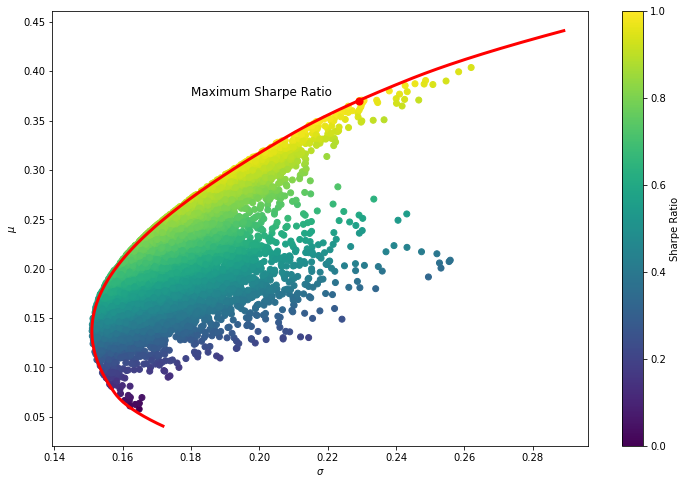

In [60]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\mu$')
plt.plot(frontier_x[45:-10],frontier_y[45:-10], 'r-', linewidth=3)
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50)
plt.text(0.18, 0.375, "Maximum Sharpe Ratio", fontsize=12)
plt.colorbar(label='Sharpe Ratio')
plt.savefig('cover.png')
plt.show()

In [49]:
np.random.random?